In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import networkx as nx
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

import json

In [2]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df[df['categories'] == 'Entertainment'] # Filter out all videos with the category "Entertainment"
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])

In [14]:
df.view_count.describe()

count    3.166400e+04
mean     2.059400e+05
std      1.191988e+06
min      3.000000e+03
25%      9.582750e+03
50%      2.297400e+04
75%      7.428350e+04
max      7.619722e+07
Name: view_count, dtype: float64

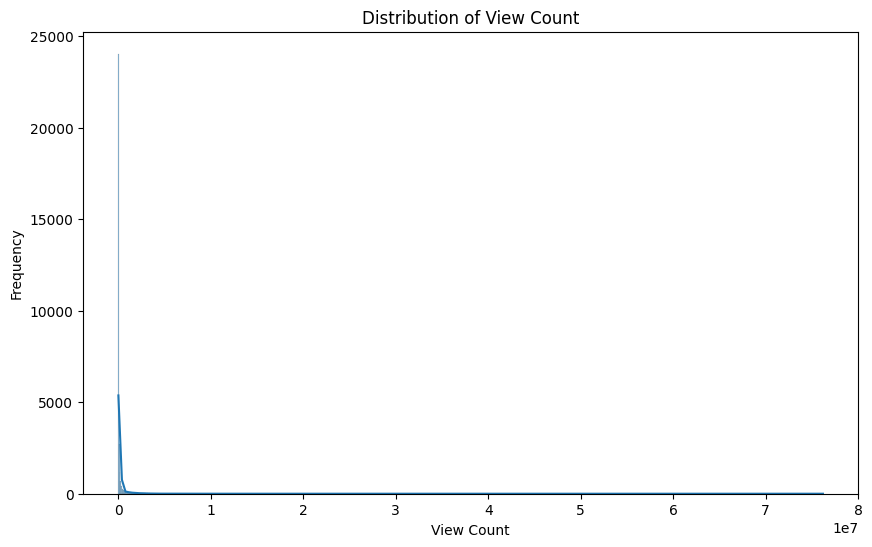

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['view_count'], bins=1000, kde=True)  
plt.title('Distribution of View Count')
plt.xlabel('View Count')
plt.ylabel('Frequency')

plt.show()

# 1. Explore whether the keywords related to Trump's conspiracy theories can help the video gain more likes overall
We observed that the distribution of the view count is severely right-skewed. We want to filter out videos with high view counts and those published by channels that have posted a significant number of videos related to Trump in the entertainment category.



In [16]:
df = df[df['view_count'] >= 3000] # Filter out videos with view counts greater than or equal to 3000.
# Filter out all channel IDs that have produced 8 or more entertainment videos related to Trump.
channel_counts = df['channel_id'].value_counts()
channel_ids = channel_counts[channel_counts >= 8]
channel_ids.describe()

count      322.000000
mean        85.437888
std        824.323458
min          8.000000
25%         11.000000
50%         18.000000
75%         38.000000
max      14764.000000
Name: count, dtype: float64

In [17]:
valid_channel_ids = channel_ids.index
df = df[df['channel_id'].isin(valid_channel_ids)]

Next, we will divide the dataset into two groups: videos containing keywords related to Trump's conspiracy theories as the treated group, and the remaining videos as the control group for comparative analysis.

In [23]:
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

## 1.1 Conduct a rough comparison between the two groups

In [22]:
treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags.
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags.

In [24]:
treated.like_count.describe()

count      557.000000
mean      2397.095153
std       2620.605348
min         15.000000
25%        703.000000
50%       1459.000000
75%       3640.000000
max      23551.000000
Name: like_count, dtype: float64

In [25]:
control.like_count.describe()

count    2.695400e+04
mean     3.393077e+03
std      1.354564e+04
min      0.000000e+00
25%      3.950000e+02
50%      1.031000e+03
75%      2.277000e+03
max      1.235449e+06
Name: like_count, dtype: float64

We noticed that the mean like_count of the treated group is less than that of the control group, but the median is greater than that of the control group.

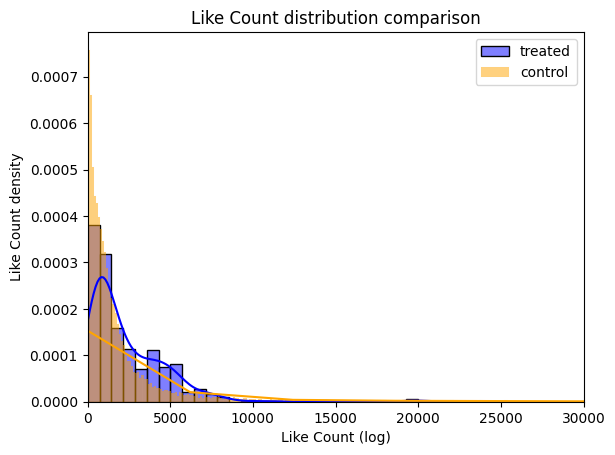

In [26]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

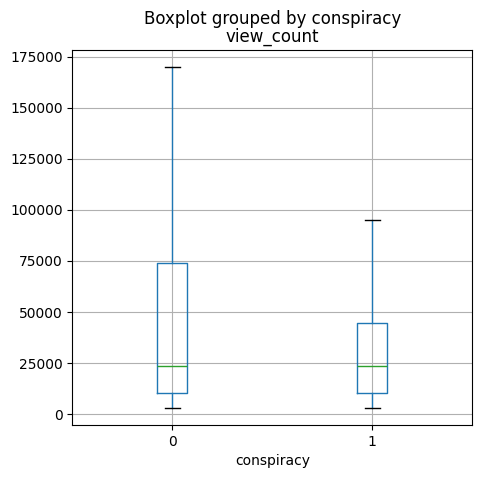

In [27]:
df.boxplot(by='conspiracy', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

 Intuitively, view count may be an important factor affecting the number of likes. From this boxplot, we can see that although the means of the two groups are close, it seems that the control group has a higher upper limit for view count.

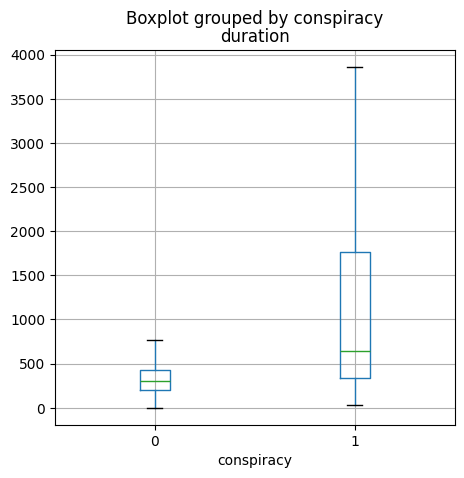

In [28]:
df.boxplot(by='conspiracy', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

An interesting finding is that the videos in the treated group are often longer than those in the control group.

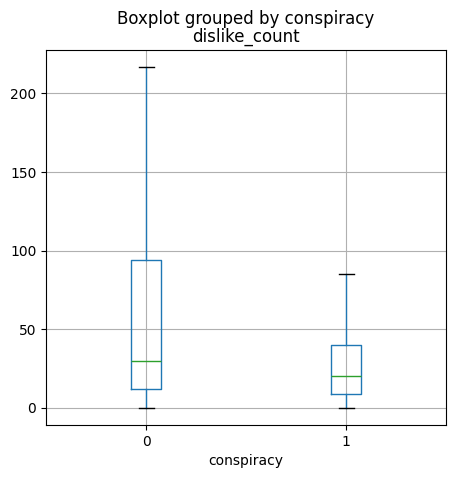

In [29]:
df.boxplot(by='conspiracy', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

The control group often has more dislikes than the treated group.

## 1.2 Balance the data

Many factors can influence the like count, and it is challenging to find two nearly identical videos for comparison. Therefore, we use propensity scores to balance the impact of other factors.

In [30]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.096073
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:                27511
Model:                          Logit   Df Residuals:                    27507
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                 0.02953
Time:                        17:11:29   Log-Likelihood:                -2643.1
converged:                       True   LL-Null:                       -2723.5
Covariance Type:            nonrobust   LLR p-value:                 1.189e-34
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.4204      0.108    -40.919      0.000      -4.632      -4.209
dislike_count    -5

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


It is noted that the computational cost of the `nx.max_weight_matching` function is $O(n^3)$, and since the control group has too much data, we will perform random sampling on the control group before matching.

In [32]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags.
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags.
control_sample = control.sample(frac=0.021, random_state=42) # Randomly sample from the control group to reduce running time.

# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in control_sample.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [33]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_1 = df.loc[df.index.isin(matched)]

# 2. Analyze the balanced groups

In [34]:
treated = balanced_df_1.loc[balanced_df_1['conspiracy'] == 1]
control = balanced_df_1.loc[balanced_df_1['conspiracy'] == 0]

In [35]:
treated.like_count.describe()

count      557.000000
mean      2397.095153
std       2620.605348
min         15.000000
25%        703.000000
50%       1459.000000
75%       3640.000000
max      23551.000000
Name: like_count, dtype: float64

In [36]:
control.like_count.describe()

count      557.000000
mean      2374.005386
std       4291.889828
min          6.000000
25%        441.000000
50%       1054.000000
75%       2155.000000
max      33012.000000
Name: like_count, dtype: float64

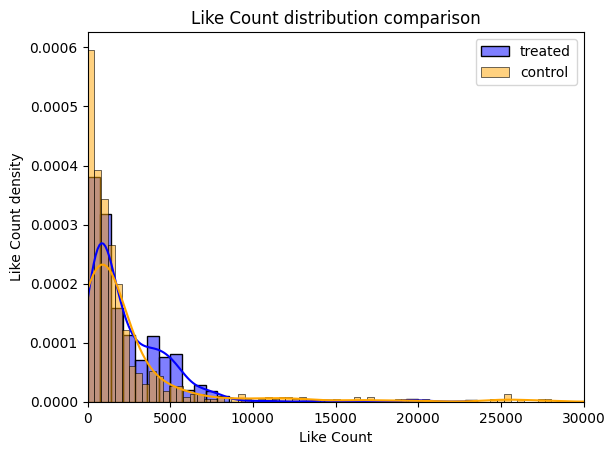

In [38]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

We can see that the median and mean of the treated group are slightly higher than those of the control group.

In [39]:
stats.ttest_ind(treated['like_count'], control['like_count'], alternative='greater') # t-Test

TtestResult(statistic=0.10836544977385142, pvalue=0.45686267817793047, df=1112.0)

Perform a t-test between the two groups, and the p-value is not sufficient to conclude that the like count in the treated group is greater than that in the control group.

# 3. Analyze the videos of a specific channel

The dataset does not include the subscriber count of the channels, but I believe that the subscriber count itself may be a factor influencing the like count. Therefore, we will attempt to conduct the above analysis for specific channels.

In [40]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # read the dataset
df = df[df['categories'] == 'Entertainment'] # Filter out all videos with the category "entertainment."
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])


In [41]:
channel_counts = df['channel_id'].value_counts()
channel_counts

channel_id
UCLoNQH9RCndfUGOb2f7E1Ew    15180
UCMtFAi84ehTSYSE9XoHefig      983
UCK7IIV6Q2junGSdYK3BmZMg      534
UCY2BjyN1fEe1JIE3J2xzMUw      471
UCpM_hmOVus872lSLIdbirXQ      463
                            ...  
UCwYOFq7ytT-jMWL5cAoqDow        1
UCwX9bQ8RVbOISgm_Uipnvqw        1
UCwWnMcPoBohPkYQ0HVV2cew        1
UCSPNAYs5lt0bY7M7m-MnU2g        1
UCrx-BsB_G0WDMG9SeCOpARg        1
Name: count, Length: 3571, dtype: int64

We noticed that one channel still has over 10,000 video entries in the filtered dataset. We will use this channel for our analysis.

In [42]:
df = df[df['channel_id'] == 'UCLoNQH9RCndfUGOb2f7E1Ew']

with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags.
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags.

The above code simply repeats the operations from Section 1.

In [43]:
treated.like_count.describe()

count      235.000000
mean      1914.391489
std       2240.438453
min        186.000000
25%        806.000000
50%       1340.000000
75%       2293.500000
max      19599.000000
Name: like_count, dtype: float64

In [44]:
control.like_count.describe()

count    14945.000000
mean      1779.545734
std       2394.446219
min          3.000000
25%        607.000000
50%       1143.000000
75%       2031.000000
max      55783.000000
Name: like_count, dtype: float64

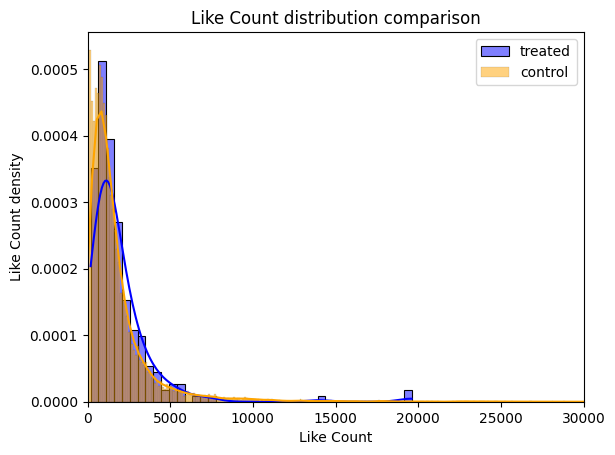

In [45]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

Before balancing the data, both the median and mean of the treated group are higher than those of the control group.

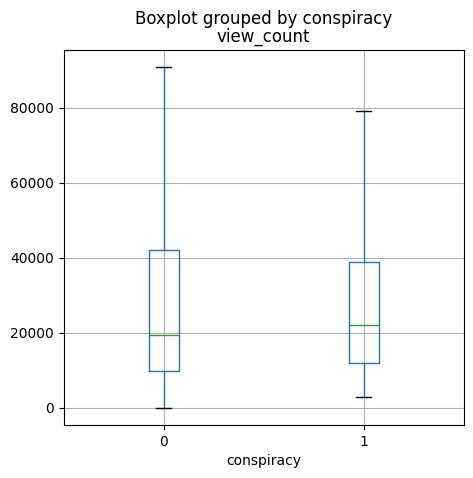

In [46]:
df.boxplot(by='conspiracy', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

 Although the median view_count of the treated group is higher than that of the control group, the control group has a higher upper quatile for view_count.

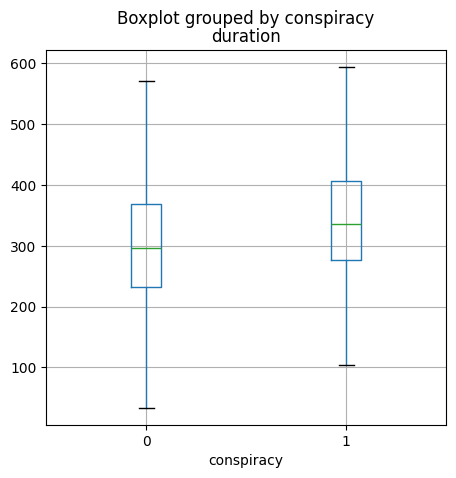

In [47]:
df.boxplot(by='conspiracy', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

The video duration of the treated group is often longer than that of the control group.

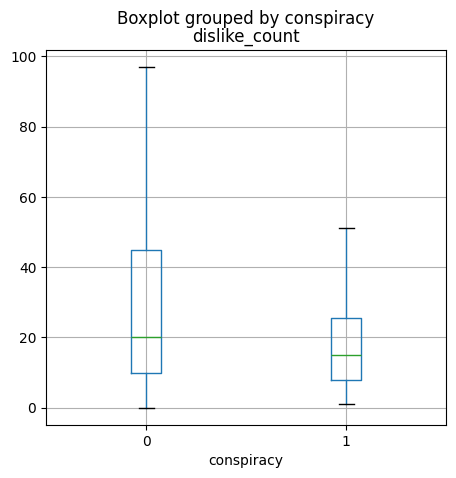

In [48]:
df.boxplot(by='conspiracy', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

The control group often has more dislikes than the treated group.

In [49]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.078021
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:                15180
Model:                          Logit   Df Residuals:                    15176
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                 0.02336
Time:                        19:00:43   Log-Likelihood:                -1184.4
converged:                       True   LL-Null:                       -1212.7
Covariance Type:            nonrobust   LLR p-value:                 3.058e-12
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.5796      0.121    -37.725      0.000      -4.818      -4.342
dislike_count    -5

In [50]:
treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags
control_sample = control.sample(frac=0.04, random_state=42) # Randomly sample from the control group to reduce running time

# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in control_sample.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [51]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_1 = df.loc[df.index.isin(matched)]

treated = balanced_df_1.loc[balanced_df_1['conspiracy'] == 1]
control = balanced_df_1.loc[balanced_df_1['conspiracy'] == 0]

In [52]:
treated.like_count.describe()

count      235.000000
mean      1914.391489
std       2240.438453
min        186.000000
25%        806.000000
50%       1340.000000
75%       2293.500000
max      19599.000000
Name: like_count, dtype: float64

In [53]:
control.like_count.describe()

count      235.000000
mean      1700.234043
std       1910.509352
min         66.000000
25%        650.500000
50%       1197.000000
75%       2054.500000
max      17656.000000
Name: like_count, dtype: float64

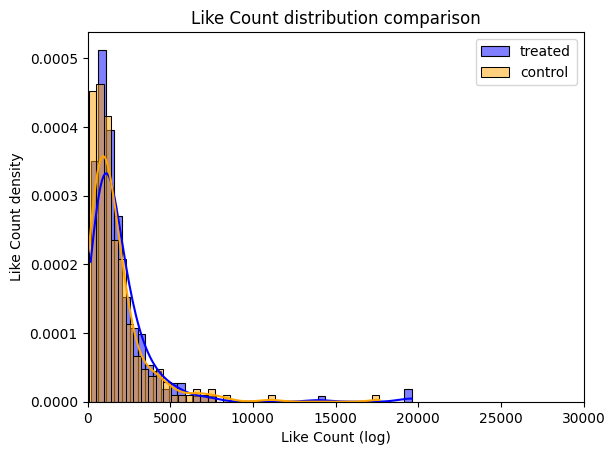

In [54]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count (log)', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

Both the mean and median of the treated group are higher than those of the control group. It can also be seen that the treated group has a larger proportion in the range of 3000 to 6000 likes.

In [55]:
stats.ttest_ind(treated['like_count'], control['like_count'], alternative='greater') # t-Test

TtestResult(statistic=1.1149806228405426, pvalue=0.13271547494026262, df=468.0)

Although the p-value is not less than 0.05, it decreases significantly after limiting the study to a specific channel.